# Base Model

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# variable initializations
PATH = "../cancer_data_split/" 
BATCH_SIZE = 128 
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
MONITOR = "val_accuracy" 
MODE = "max"
PATIENCE = 2
CHECKPOINT_PATH = "./inception_checkpoints" 
MODEL_NAME = "best_model" 
LEARNING_RATE = 0.000001

In [3]:
# load the preprocess input of the inceptionV3 model
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

# Create the base model from the pre-trained model inceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [4]:
def load_data(path, batch_size, image_size):
    """[summary]

    Args:
        path: path of the dataset
        batch_size: variable that stores the batch size that will be used in the training
        image_size: size of the image, e.g. (224, 224) or (32, 32),  etc.

    Returns:
        train: the training dataset retrieved from the path 
        val: the val dataset retrieved from the path 
        test: the test dataset retrieved from the path 
    """
    train_dir = os.path.join(path, 'train')
    validation_dir = os.path.join(path, 'val')
    test_dir = os.path.join(path, 'test')


    train = image_dataset_from_directory(train_dir,
                                         shuffle=True,
                                         batch_size=BATCH_SIZE,
                                         image_size=IMG_SIZE)

    val = image_dataset_from_directory(validation_dir,
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

    test = image_dataset_from_directory(test_dir,
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)
    return train, val, test

train_dataset, validation_dataset, test_dataset = load_data(PATH, BATCH_SIZE, IMG_SIZE)

Found 115386 files belonging to 2 classes.
Found 38461 files belonging to 2 classes.
Found 38465 files belonging to 2 classes.


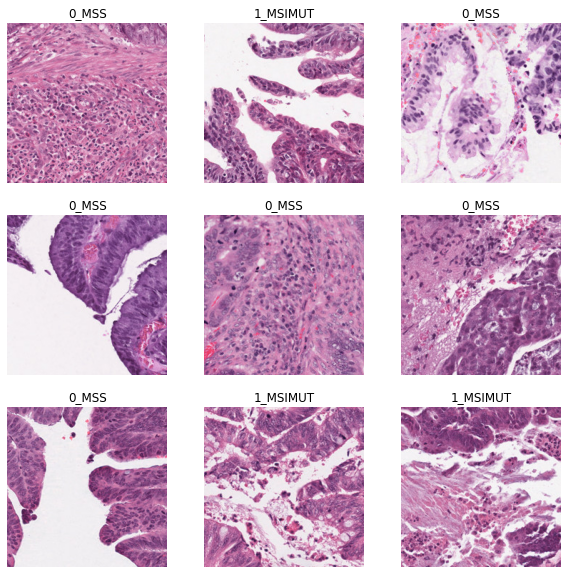

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# freeze the model
base_model.trainable = False

In [8]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
def create_model(base_model, input_shape):
    """[summary]

    Args:
        base_model:
        input_shape:

    Returns:
        model: 
    """
    flatten_layer = tf.keras.layers.Flatten()
    dense_layer1 = tf.keras.layers.Dense(4096, activation='relu')
    dense_layer2 = tf.keras.layers.Dense(4096, activation='relu')
    prediction_layer = tf.keras.layers.Dense(1)
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = flatten_layer(x)
    x = dense_layer1(x)
    x = dense_layer2(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [10]:
# Set up early stopping and model saving
def create_callbacks(monitor, mode, patience, path, model_name):
    """[summary]

    Args:
        monitor: [description]
        mode: [description]
        patience: [description]
        path: [description]
        model_name: [description]

    Returns:
        early_checkpoint: 
        val_acc_checkpoint:
    """
    early_checkpoint = EarlyStopping(patience=patience, monitor=monitor, mode=mode)
    val_acc_checkpoint = ModelCheckpoint(os.path.join(path, model_name), monitor=monitor, mode=mode, save_best_only=True, verbose=1)
    return early_checkpoint, val_acc_checkpoint

callbacks = [create_callbacks(MONITOR, MODE, PATIENCE, CHECKPOINT_PATH, MODEL_NAME)]

In [11]:
model = create_model(base_model, IMG_SHAPE)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/10
902/902 [==============================] - 13285s 15s/step - loss: 0.5994 - accuracy: 0.6694 - val_loss: 0.5707 - val_accuracy: 0.6884

Epoch 00001: val_accuracy improved from -inf to 0.68844, saving model to ./inception_checkpoints\best_model
INFO:tensorflow:Assets written to: ./inception_checkpoints\best_model\assets
Epoch 2/10
902/902 [==============================] - 23650s 26s/step - loss: 0.5344 - accuracy: 0.7128 - val_loss: 0.5525 - val_accuracy: 0.7042

Epoch 00002: val_accuracy improved from 0.68844 to 0.70417, saving model to ./inception_checkpoints\best_model
INFO:tensorflow:Assets written to: ./inception_checkpoints\best_model\assets
Epoch 3/10
902/902 [==============================] - 17735s 20s/step - loss: 0.4936 - accuracy: 0.7394 - val_loss: 0.5417 - val_accuracy: 0.7196

Epoch 00003: val_accuracy improved from 0.70417 to 0.71961, saving model to ./inception_checkpoints\best_model
INFO:tensorflow:Assets written to: ./inception_checkpoints\best_model\asset

In [13]:
best_model = tf.keras.models.load_model('inception_checkpoints/best_model/') 

In [23]:
best_model.evaluate(test_dataset)

 90/301 [=======>......................] - ETA: 19:01 - loss: 0.5258 - accuracy: 0.7332

KeyboardInterrupt: 

# Model fine tuning 

In [11]:
# unfreeze model
base_model.training = True

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [13]:
# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
def create_finetune_model(base_model, input_shape):
    """[summary]

    Args:
        base_model:
        input_shape:

    Returns:
        model: 
    """
    last_layer = base_model.get_layer('mixed7')
    last_output = last_layer.output
    flatten_layer = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = Model(pre_trained_model.input, x)

    flatten_layer = tf.keras.layers.Flatten()
    dense_layer1 = tf.keras.layers.Dense(4096, activation='relu')
    dense_layer2 = tf.keras.layers.Dense(4096, activation='relu')
    prediction_layer = tf.keras.layers.Dense(1)
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = flatten_layer(x)
    x = dense_layer1(x)
    x = dense_layer2(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [14]:
model = create_finetune_model(base_model, IMG_SHAPE)

In [15]:
# Set up early stopping and model saving
MODEL_NAME = "best_finetuned_model" 

callbacks = [create_callbacks(MONITOR, MODE, PATIENCE, CHECKPOINT_PATH, MODEL_NAME)]


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=8,
                         validation_data=validation_dataset,
                         callbacks = callbacks)

Epoch 9/20
902/902 [==============================] - 10411s 12s/step - loss: 0.6006 - accuracy: 0.6709 - val_loss: 0.5705 - val_accuracy: 0.6916

Epoch 00009: val_accuracy improved from -inf to 0.69164, saving model to ./inception_checkpoints\best_finetuned_model
INFO:tensorflow:Assets written to: ./inception_checkpoints\best_finetuned_model\assets
Epoch 10/20
902/902 [==============================] - 16338s 18s/step - loss: 0.5342 - accuracy: 0.7141 - val_loss: 0.5525 - val_accuracy: 0.7083

Epoch 00010: val_accuracy improved from 0.69164 to 0.70830, saving model to ./inception_checkpoints\best_finetuned_model
INFO:tensorflow:Assets written to: ./inception_checkpoints\best_finetuned_model\assets
Epoch 11/20
902/902 [==============================] - 14587s 16s/step - loss: 0.4940 - accuracy: 0.7402 - val_loss: 0.5421 - val_accuracy: 0.7203

Epoch 00011: val_accuracy improved from 0.70830 to 0.72029, saving model to ./inception_checkpoints\best_finetuned_model
INFO:tensorflow:Assets 

In [ ]:
finetuned_model = tf.keras.models.load_model('inception_checkpoints/best_finetuned_model/')


Error: Session cannot generate requests